![lop](../../images/logo_diive1_128px.png)

<span style='font-size:28px; display:block;'>
<b>
    Calculate daytime flag, nighttime flag and potential radiation from latitude and longitude
</b>
</span>

---
**Notebook version**: `2` (23 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Calculation of two flags for each record:
    - Daytime flag, where daytime=1 and nighttime=0
    - Nighttime flag, where daytime=0 and nighttime=1
- Both flags are calculated from potential radiation, whereby values below a specified threshold are nighttime
- Potential radiation is calculated from latitude and longitude

</br>

# **Imports**

In [1]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag

warnings.filterwarnings("ignore")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.83.2


</br>

# **Docstring**

In [2]:
# help(DaytimeNighttimeFlag)

</br>

</br>

# **Load example data**

In [3]:
df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.054 seconds). Detected time resolution of <30 * Minutes> / 30min 


In [4]:
df

,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,NEE_CUT_84_orig,NEE_CUT_REF_f,NEE_CUT_REF_orig,PA,PPFD,PREC_TOT_T1_25+20_1,QCF_LE,QCF_NEE,Reco_CUT_16,Reco_CUT_84,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290,0.510,-0.082,0.705,0.0,0.0,0.0,13.093,NaN,194.913,1.376,NaN,1.537,NaN,1.595,NaN,832.520,0.017,0.0,NaN,1.0,1.886,1.455,2.300,1.252,1.908,1.613,0.510,0.0,0.0,31.933,34.977,-1.618,-1.618,0.288,1.339,1.339
2013-01-01 00:45:00,0.290,0.512,-0.084,0.708,0.0,0.0,0.0,13.093,NaN,193.568,1.376,NaN,1.537,NaN,1.595,NaN,832.430,0.031,0.0,NaN,NaN,1.888,1.454,2.303,1.241,1.914,1.616,0.512,0.0,0.0,32.600,34.977,-1.630,-1.630,0.288,1.337,1.337
2013-01-01 01:15:00,0.290,0.514,-0.086,0.710,0.0,0.0,0.0,13.066,NaN,193.135,1.376,NaN,1.537,NaN,1.595,NaN,832.207,-0.006,0.0,NaN,1.0,1.890,1.452,2.305,1.230,1.920,1.619,0.515,0.0,0.0,38.867,34.971,-1.644,-1.644,0.288,1.335,1.335
2013-01-01 01:45:00,0.290,1.354,-0.088,1.771,0.0,0.0,0.0,13.066,NaN,192.083,0.538,0.538,1.537,NaN,0.538,0.538,831.903,-0.018,0.0,NaN,0.0,1.892,1.450,2.308,1.219,1.926,1.622,0.518,0.0,0.0,37.767,34.975,-1.657,-1.657,0.288,1.332,1.332
2013-01-01 02:15:00,0.377,0.545,-0.080,0.797,0.0,0.0,0.0,16.995,NaN,192.677,1.544,NaN,1.709,NaN,1.765,NaN,831.680,0.007,0.0,NaN,1.0,2.090,1.630,2.562,1.347,2.105,1.790,0.578,0.0,0.0,39.533,34.967,-0.567,-0.567,0.288,3.545,3.545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016,0.373,0.203,0.600,0.0,0.0,0.0,-0.735,-0.735,230.499,0.629,NaN,1.253,NaN,1.224,NaN,842.985,0.000,0.0,1.0,1.0,1.001,1.456,1.824,2.568,1.221,1.032,0.759,0.0,0.0,71.790,19.572,3.463,3.463,0.288,2.210,2.210
2022-12-31 22:15:00,0.105,-2.379,0.894,-1.433,0.0,0.0,0.0,4.724,4.724,231.788,3.518,3.518,0.803,NaN,3.518,3.518,842.976,0.000,0.0,0.0,0.0,1.139,1.697,2.085,2.959,1.356,1.174,0.838,0.0,0.0,62.627,19.577,5.283,5.283,0.288,3.327,3.327
2022-12-31 22:45:00,0.220,-0.515,0.926,-0.305,0.0,0.0,0.0,9.840,NaN,237.303,1.673,NaN,0.803,NaN,2.424,NaN,842.965,0.000,0.0,2.0,1.0,1.158,1.729,2.119,3.038,1.367,1.199,0.857,0.0,0.0,61.747,19.589,5.537,5.537,0.288,3.467,3.467


</br>

</br>

# **Calculation of flags from potential radiation**

In [5]:
dnf = DaytimeNighttimeFlag(
    timestamp_index=df.index,
    nighttime_threshold=1,
    lat=47.286417,
    lon=7.733750,
    utc_offset=1
)

## Results

In [6]:
results = dnf.get_results()
results

,SW_IN_POT,DAYTIME,NIGHTTIME
TIMESTAMP_MIDDLE,,,
2013-01-01 00:15:00,0.0,0.0,1.0
2013-01-01 00:45:00,0.0,0.0,1.0
2013-01-01 01:15:00,0.0,0.0,1.0
2013-01-01 01:45:00,0.0,0.0,1.0
2013-01-01 02:15:00,0.0,0.0,1.0
...,...,...,...
2022-12-31 21:45:00,0.0,0.0,1.0
2022-12-31 22:15:00,0.0,0.0,1.0
2022-12-31 22:45:00,0.0,0.0,1.0


In [7]:
dnf.get_swinpot()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.0
2013-01-01 00:45:00    0.0
2013-01-01 01:15:00    0.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30min, Name: SW_IN_POT, Length: 175296, dtype: float64

In [8]:
dnf.get_daytime_flag()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.0
2013-01-01 00:45:00    0.0
2013-01-01 01:15:00    0.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30min, Name: DAYTIME, Length: 175296, dtype: float64

In [9]:
dnf.get_nighttime_flag()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    1.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    1.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: NIGHTTIME, Length: 175296, dtype: float64

</br>

</br>

# **Plot some variables**

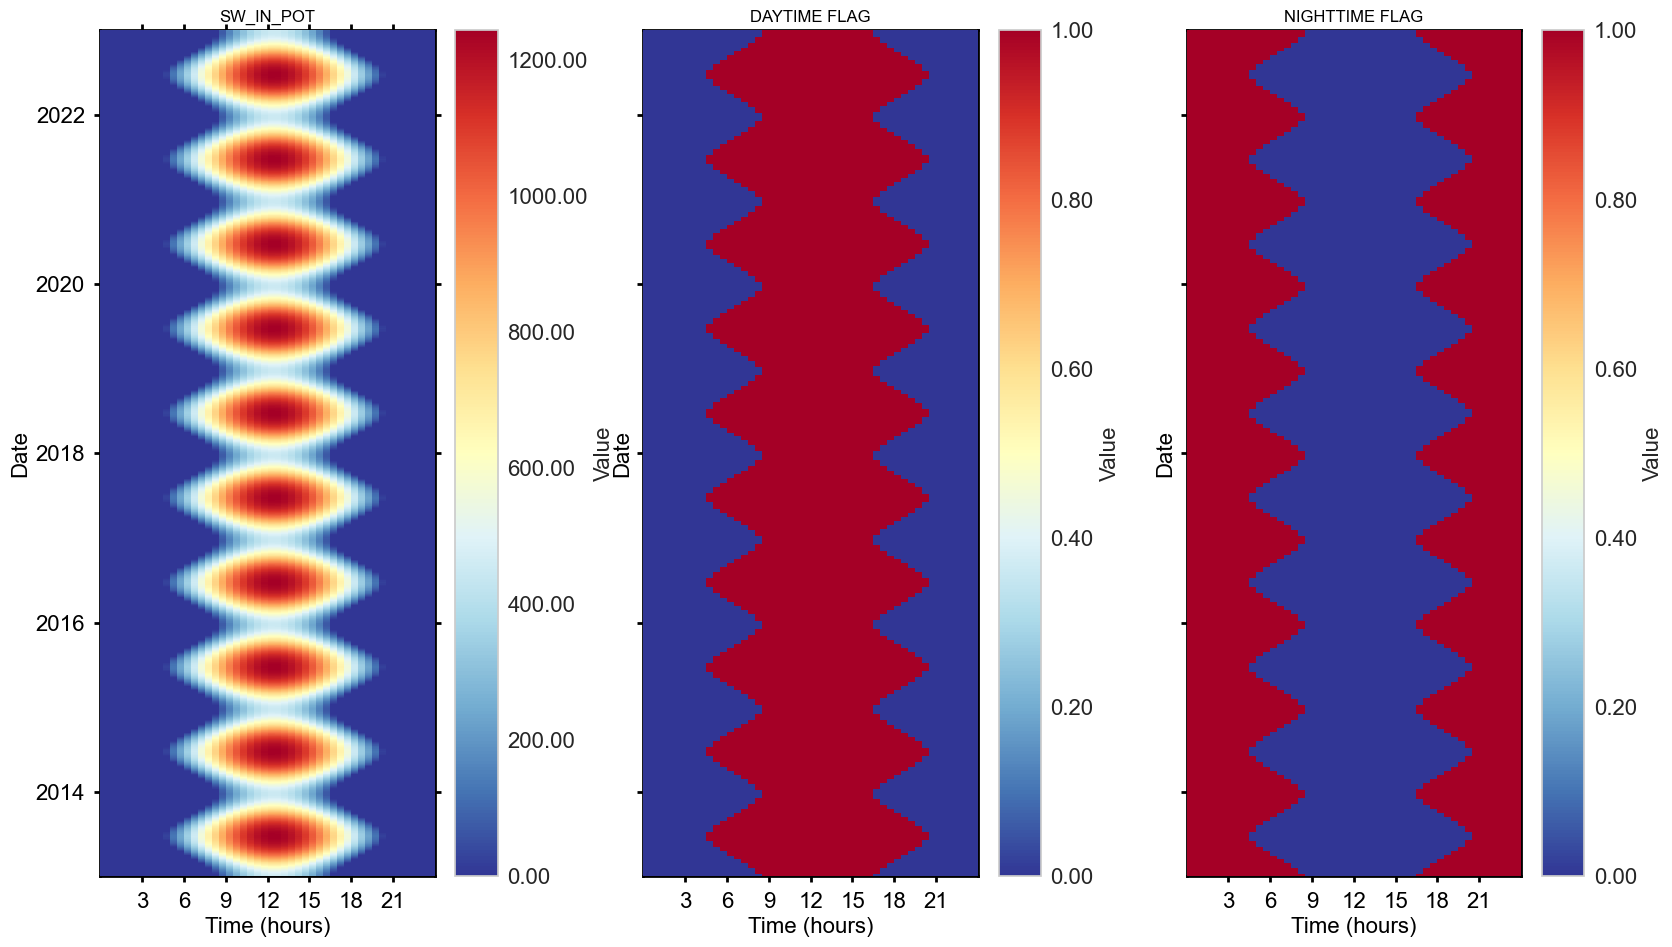

In [10]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
gs.update(wspace=0.3, hspace=0.3, left=0.03, right=0.97, top=0.97, bottom=0.03)
ax_sw = fig.add_subplot(gs[0, 0])
ax_dt = fig.add_subplot(gs[0, 1])
ax_nt = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_sw, series=dnf.get_swinpot()).plot()
HeatmapDateTime(ax=ax_dt, series=dnf.get_daytime_flag()).plot()
HeatmapDateTime(ax=ax_nt, series=dnf.get_nighttime_flag()).plot()
ax_sw.set_title("SW_IN_POT", color='black')
ax_dt.set_title("DAYTIME FLAG", color='black')
ax_nt.set_title("NIGHTTIME FLAG", color='black')
ax_dt.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_nt.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)

</br>

# **End of notebook**

In [11]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-10-24 13:42:12
